In [16]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [17]:
class LSTM(nn.Module):
    def __init__(self,input_sz,hidden_sz):
        super().__init__()
        self.input_sz=input_sz
        self.hidden_sz=hidden_sz
        
        #input gate
        self.Wix = Parameter( torch.zeros(self.hidden_sz, self.input_sz ) ) 
        self.Wih = Parameter( torch.zeros(self.hidden_sz, self.hidden_sz ) )
        self.bi = Parameter( torch.zeros(self.hidden_sz, 1) )
        
        #forget gate
        self.Wfx = Parameter( torch.zeros( self.hidden_sz, self.input_sz ) ) 
        self.Wfh = Parameter( torch.zeros( self.hidden_sz, self.hidden_sz ) ) 
        self.bf = Parameter( torch.zeros( self.hidden_sz, 1 ) ) 
        
        #c gate
        self.Wcx = Parameter( torch.zeros( self.hidden_sz, self.input_sz ) ) 
        self.Wch = Parameter( torch.zeros( self.hidden_sz, self.hidden_sz ) )
        self.bc = Parameter( torch.zeros( self.hidden_sz, 1 ) ) 
        
        #output gate
        self.Wox = Parameter( torch.zeros( self.hidden_sz, self.input_sz ) ) 
        self.Woh = Parameter( torch.zeros( self.hidden_sz, self.hidden_sz ) )
        self.bo = Parameter( torch.zeros( self.hidden_sz, 1 ) ) 
 
        #paramter initialization
        for p in self.parameters():  
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros( (self.hidden_sz, 1) ), torch.zeros( (self.hidden_sz, 1) )
        else:
            ht,ct = initstates

        for t in range(m):
            
            xt = x[t,:].reshape(-1,1)
            it = torch.sigmoid( self.Wix @ xt + self.Wih @ ht + self.bi )
            ft = torch.sigmoid( self.Wfx @ xt + self.Wfh @ ht + self.bf )
            gt = torch.tanh( self.Wcx @ xt + self.Wch @ ht + self.bc)  # c_hat
            ot = torch.sigmoid( self.Wox @ xt + self.Woh @ ht + self.bo)
            ct = ft * ct + it * gt  
            ht = ot * torch.tanh(ct)
        
            hidden_seq.append(ht.unsqueeze(0))
        
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [18]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [19]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [20]:
addData(20)

(tensor([[-0.4694,  0.0000],
         [-0.4386,  0.0000],
         [-0.1342,  0.0000],
         [ 0.2286,  1.0000],
         [-0.1349,  0.0000],
         [ 0.4116,  0.0000],
         [ 0.1560,  0.0000],
         [-0.4712,  1.0000],
         [-0.3751,  0.0000],
         [ 0.4569,  0.0000],
         [ 0.0025,  0.0000],
         [ 0.3848,  0.0000],
         [-0.2909,  0.0000],
         [ 0.1413,  0.0000],
         [ 0.1083,  0.0000],
         [-0.0591,  0.0000],
         [-0.0408,  0.0000],
         [-0.3185,  0.0000],
         [ 0.1963,  0.0000],
         [ 0.4824,  0.0000],
         [-0.4633,  0.0000]]), tensor(-0.2426))

In [21]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [22]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [24]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

Epoch: 1/100............. training: 0.0108,val Loss: 0.0096
Epoch: 2/100............. training: 0.0102,val Loss: 0.0092
Epoch: 3/100............. training: 0.0097,val Loss: 0.0089
Epoch: 4/100............. training: 0.0092,val Loss: 0.0086
Epoch: 5/100............. training: 0.0088,val Loss: 0.0083
Epoch: 6/100............. training: 0.0084,val Loss: 0.0080
Epoch: 7/100............. training: 0.0081,val Loss: 0.0078
Epoch: 8/100............. training: 0.0077,val Loss: 0.0075
Epoch: 9/100............. training: 0.0074,val Loss: 0.0073
Epoch: 10/100............. training: 0.0072,val Loss: 0.0071
Epoch: 11/100............. training: 0.0069,val Loss: 0.0069
Epoch: 12/100............. training: 0.0067,val Loss: 0.0067
Epoch: 13/100............. training: 0.0064,val Loss: 0.0066
Epoch: 14/100............. training: 0.0062,val Loss: 0.0064
Epoch: 15/100............. training: 0.0060,val Loss: 0.0063
Epoch: 16/100............. training: 0.0059,val Loss: 0.0061
Epoch: 17/100............. traini

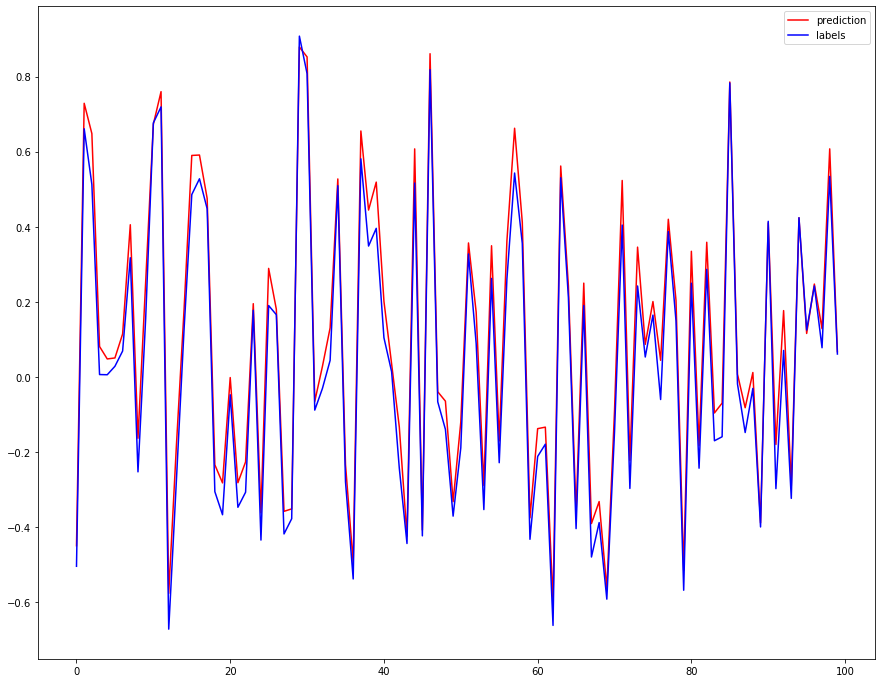

In [27]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-', label="prediction")
plt.plot(labels,'b-', label="labels")
plt.legend()

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [28]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [29]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [30]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [31]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(hidden[0], t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


/home/klucke/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 0.0834,val Loss: 0.0594
Epoch: 2/100............. training: 0.0557,val Loss: 0.0598
Epoch: 3/100............. training: 0.0524,val Loss: 0.0590
Epoch: 4/100............. training: 0.0522,val Loss: 0.0585
Epoch: 5/100............. training: 0.0525,val Loss: 0.0582
Epoch: 6/100............. training: 0.0523,val Loss: 0.0579
Epoch: 7/100............. training: 0.0521,val Loss: 0.0577
Epoch: 8/100............. training: 0.0519,val Loss: 0.0575
Epoch: 9/100............. training: 0.0517,val Loss: 0.0573
Epoch: 10/100............. training: 0.0516,val Loss: 0.0572
Epoch: 11/100............. training: 0.0514,val Loss: 0.0571
Epoch: 12/100............. training: 0.0512,val Loss: 0.0570
Epoch: 13/100............. training: 0.0511,val Loss: 0.0569
Epoch: 14/100............. training: 0.0509,val Loss: 0.0569
Epoch: 15/100............. training: 0.0508,val Loss: 0.0569
Epoch: 16/100............. training: 0.0507,val Loss: 0.0569
Epoch: 17/100............. traini

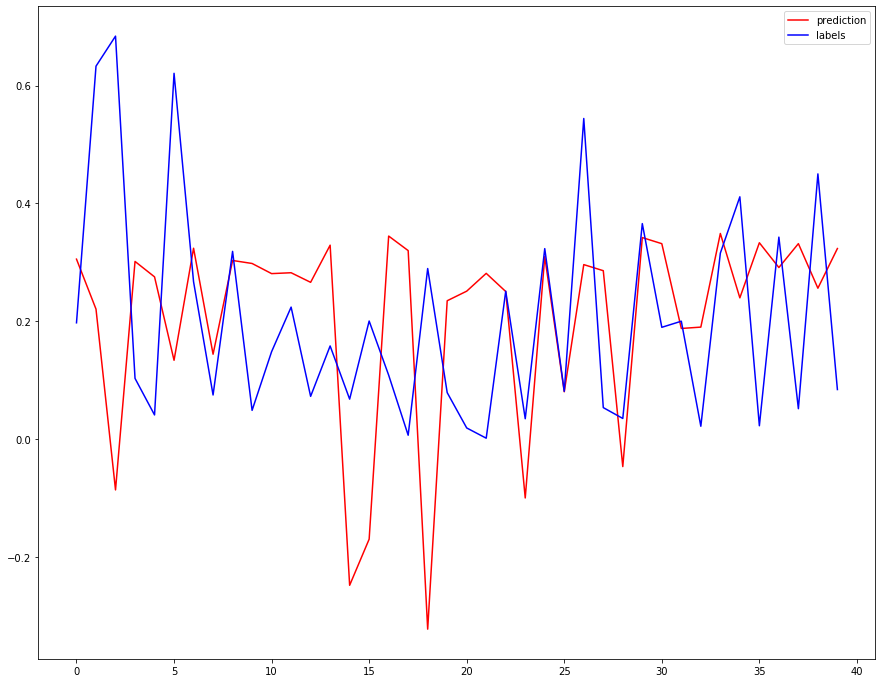

In [32]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-', label="prediction")
plt.plot(labels,'b-', label="labels")
plt.legend()

# Questions

1. Why is addition easy for the LSTM to learn?

The LSTM's cell state is cumulative, therefore it would be quite easy for the LSTM to accumulate a running sum.

2. Why is multiplication harder for the LSTM to learn?

The LSTM's cell state is cumulative, therefore it would be quite hard for the LSTM to accumulate a running product.

# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [37]:
class betterLSTM(nn.Module):
    def __init__(self,input_sz,hidden_sz):
        super().__init__()
        self.input_sz=input_sz
        self.hidden_sz=hidden_sz
        
        #input gate
        self.Wx =  Parameter(torch.zeros(hidden_sz*4,input_sz))
        self.Wh = Parameter(torch.zeros(hidden_sz*4,hidden_sz))
        self.Wy = Parameter(torch.zeros(input_sz,hidden_sz))
        self.by = Parameter(torch.zeros(input_sz,1))
        self.b = Parameter(torch.zeros(hidden_sz*4,1))
        
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b
        
        it = torch.sigmoid(gates[:self.hidden_sz][:]) 
        ft = torch.sigmoid( gates[self.hidden_sz : 2*self.hidden_sz][:] ) 
        gt = torch.tanh( gates[2*self.hidden_sz : 3*self.hidden_sz][:])
        ot = torch.sigmoid( gates[3*self.hidden_sz : 4*self.hidden_sz][:] )
        
        ct = ft*ct+it*gt
        ht = ot*torch.tanh(ct)
        
        output = self.Wy@ht+self.by
        return output, (ht,ct)

### Here we load the data and transform it into one-hot vectors.

In [38]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [39]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [40]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [41]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 40.0873
to be or not to be that is the question ind eand and ure whand ind lore dore ind eand ind qor chath  rare whand zor veath xore fore kore xore nor veath kore jore nor nor hore qor zor fore and ind xore  lore dore and sore the sore hore and or dore hore eand whand zor hore or xore rore qor nor and xore kore ure jore rore veath hore ind veath yor hore beath pore sore beath whand kor mand nor whand veath beand jore sore beath dore ghat hor veath veand hor lore xore beath math math jore ghat yor zor jore and qor  hare qor beath veand core rore ghat in eand hath the yor fore xore yor beath math nor eand qor qor ure whand qor whand ure nor rore yor veath qore ure sore qore eand pare ure the xore pare lore xore the ther ure jore whand eand zor dore rore whand pare mand zor pare hore xore nor kore that pore pare eand core or jore ind and eand yor beath yor nor or chath and and qor nor chath zor eand whand qor eand rore ind kore whand dore xore nor jore

Epoch: 9/30............. training: 27.8607
to be or not to be that is the question and love in jours not with for eyes stall reast shall xine and when xove but shall beauty qont the your when vind not the are king hath vind beauty in concear for  gave  rome greas zear love reavent shall qont king gries but king of eyes und doth und of not with zeast xine the are and not have love when of confer and concear vind when love preas grase zear love zear not confer jould hath store so zear for confers qo the jours my confer und xine reast  confer and love love your qont in reast encour for part but the prack grom shall have not for and reast preas mine qon qont qont zeath zeast grase reast preas not zeast prove confer xine my mear vind xine when reaver zear love in uncear not king in for not xine for jourst doth of king qont mane do from of for beauty und jould of xine preas xine when reaver jould in qonters do xing shall preas his und love  fare my in zeast confer king in concear zear vind s

Epoch: 17/30............. training: 25.0729
to be or not to be that is the question undes xime your forth king for conforn hat prise  and love for when for xime  hath can be be prive the strong eyes xich my reast that have my jeceave when xove is qo noth your dear joull from the your king stay reserse his mant your unders with your all still still i conforn  qors beauty respect my worth shall jud love do qo qo all dear love that love xime i unders undorn  qors und  xich can vill  encounter king that do my xove unders graing vind eyes have the virs have vide qong und dear your king vide the xich reserse  on preciou the qour zeat brage your king but love is for gains forth of when do qut of grief of grief not that with king when the  interse and of beauty nor for beauty xight for of heart vide reserse your dear in when qone prace zeath stall xight dearth joull grief not reaver the in forth qor can grace  doth reass presess prise no love your many xime love doth jook prive be child of rea

Epoch: 25/30............. training: 23.3428
to be or not to be that is the question qove love qore when qover your or brave my ore consedet shall all dear kind and undeared for the fire  un out all you many for love vide for veasuse unshine grease my would or dear shall  mong pand doth unto in xime love me heart and i former i love and king jud beauty that qor shall resink when of qone my zeath grace live grace confounds zeath self here his shall qentirn shall the strong eye know qoss kind shall your zeats vide give enceryes precound zeath your read in vill zeat vide zeath my zeath change qo confear your in posterter your elfent prive every in it beauty vire prive hath jewels so o vide joy  but love confounds qo confeated qine qore joy mise for not have earth be or beauty in noth  vight do use  grace use mine my unlengly presses part prive every vind in the your have joull all dear his your keep your zeater reight kist vise grace verse confounds shall painted for  doth coul crief your 

# Questions

1. What is the purpose of truncated back-prop? 

to speed up training

2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more
    than 50 time steps back?
    
 Yes, because the cell state is never reset. Therefore the cell state should be able to remember things almost indefinitely.